In [1]:
import pygmt
import xarray as xr
import xesmf as xe

import pickle
import numpy as np
import pandas as pd

from scipy.signal import savgol_filter

from numpy import deg2rad, sin, cos, meshgrid, gradient

from pygmt.datasets import load_earth_relief
grid = load_earth_relief(resolution="06m", registration="gridline")

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
5.31*1.e20/1.e15/1.e5

5.309999999999999

In [5]:
5*1.e18/(5.31*1.e20)*100

0.9416195856873824

In [2]:
def earth_radius(lat):
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )
    return r

def area_grid(data):
    lon = grid.lon
    
    xlon, ylat = meshgrid(grid.lon.values, grid.lat.values)
    R = earth_radius(ylat)
    dlat = deg2rad(gradient(ylat, axis=0))
    dlon = deg2rad(gradient(xlon, axis=1))
    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))
    area = dy * dx
    xda = xr.DataArray(
        area,
        dims=["latitude", "longitude"],
        coords={"latitude": grid.lat.values, "longitude": grid.lon.values},
        attrs={
            "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
        },
    )
    xds = xda.to_dataset(name = 'area')
    xds['z'] = (["latitude", "longitude"], grid.values)
    return xds

da_area = area_grid(grid)

dt = 5
ntimes = -np.arange(-265,5,dt)

# Volume reef


### Limited by water depth

In [3]:
curve = 'smooth'
with open('pickle/limit_remain_'+curve+'.pkl', 'rb') as f:
    sremain = pickle.load(f)
    
with open('pickle/limit_vol_'+curve+'.pkl', 'rb') as f:
    spresVol = pickle.load(f)

with open('pickle/limit_area_'+curve+'.pkl', 'rb') as f:
    spresArea = pickle.load(f)
    
with open('pickle/limit_destroy_'+curve+'.pkl', 'rb') as f:
    sdestroy = pickle.load(f)
    
curve = 'foster'
with open('pickle/limit_remain_'+curve+'.pkl', 'rb') as f:
    fremain = pickle.load(f)
    
with open('pickle/limit_vol_'+curve+'.pkl', 'rb') as f:
    fpresVol = pickle.load(f)

with open('pickle/limit_area_'+curve+'.pkl', 'rb') as f:
    fpresArea = pickle.load(f)

with open('pickle/limit_destroy_'+curve+'.pkl', 'rb') as f:
    fdestroy = pickle.load(f)
    
with open('pickle/limit_meandepth_smooth.pkl', 'rb') as f:
    smeandepth = pickle.load(f)

with open('pickle/limit_meandepth_foster.pkl', 'rb') as f:
    fmeandepth = pickle.load(f)

In [4]:
voldestroys = np.zeros(len(sdestroy))
voldestroyf = np.zeros(len(fdestroy))
for t in range(len(ntimes)):
    vtime = ntimes[t]
    totvols = 0.
    totvolf = 0.
    for k in range(len(sdestroy)):
        val1 = sdestroy[k][sdestroy[k].time==-vtime].vol.values
        if len(val1)>0:
            tmp1 = val1[0]+0.
        else:
            tmp1 = 0.
        totvols += tmp1
        
        val2 = fdestroy[k][fdestroy[k].time==-vtime].vol.values
        if len(val2)>0:
            tmp2 = val2[0]+0.
        else:
            tmp2 = 0.
        totvolf += tmp2
    voldestroys[t] = totvols
    voldestroyf[t] = totvolf 

In [5]:
fvol = []
farea = []
fApres = []
fkeep = []
fdest = []
fsubduct = [] 
for k in range(len(fpresVol)):
    farea.append(fpresArea[k][-1]/1.e5)
    fApres.append(fpresArea[k][0]/1.e5)
    fvol.append(fpresVol[k][1]/1.e5)
    fdest.append(fpresVol[k][0]/1.e5)
    fsubduct.append(fdestroy[k].vol.sum()/1.e5)
    fkeep.append(fremain[k].vol.sum()/1.e5)
    
svol = []
sarea = []
sApres = []
skeep = []
sdest = []
ssubduct = [] 
for k in range(len(spresVol)):
    sarea.append(spresArea[k][-1]/1.e5)
    sApres.append(spresArea[k][0]/1.e5)
    svol.append(spresVol[k][1]/1.e5)
    sdest.append(spresVol[k][0]/1.e5)
    ssubduct.append(sdestroy[k].vol.sum()/1.e5)
    skeep.append(sremain[k].vol.sum()/1.e5)

### Constrained by Kiessling accumulation rate

In [6]:
curve = 'smooth'
with open('pickle/nolimit_remain_'+curve+'.pkl', 'rb') as f:
    sremaink = pickle.load(f)
    
with open('pickle/nolimit_vol_'+curve+'.pkl', 'rb') as f:
    spresVolk = pickle.load(f)

with open('pickle/nolimit_area_'+curve+'.pkl', 'rb') as f:
    spresAreak = pickle.load(f)
    
with open('pickle/nolimit_destroy_'+curve+'.pkl', 'rb') as f:
    sdestroyk = pickle.load(f)
    
curve = 'foster'
with open('pickle/nolimit_remain_'+curve+'.pkl', 'rb') as f:
    fremaink = pickle.load(f)
    
with open('pickle/nolimit_vol_'+curve+'.pkl', 'rb') as f:
    fpresVolk = pickle.load(f)

with open('pickle/nolimit_area_'+curve+'.pkl', 'rb') as f:
    fpresAreak = pickle.load(f)

with open('pickle/nolimit_destroy_'+curve+'.pkl', 'rb') as f:
    fdestroyk = pickle.load(f)

In [7]:
fvolk = []
fareak = []
fApresk = []
fkeepk = []
fdestk = []
fsubductk = [] 
for k in range(len(fpresVolk)):
    fareak.append(fpresAreak[k][-1]/1.e5)
    fApresk.append(fpresAreak[k][0]/1.e5)
    fvolk.append(fpresVolk[k][1]/1.e5)
    fdestk.append(fpresVolk[k][0]/1.e5)
    fsubductk.append(fdestroyk[k].vol.sum()/1.e5)
    fkeepk.append(fremaink[k].vol.sum()/1.e5)
    
svolk = []
sareak = []
sApresk = []
skeepk = []
sdestk = []
ssubductk = [] 
for k in range(len(spresVolk)):
    sareak.append(spresAreak[k][-1]/1.e5)
    sApresk.append(spresAreak[k][0]/1.e5)
    svolk.append(spresVolk[k][1]/1.e5)
    sdestk.append(spresVolk[k][0]/1.e5)
    ssubductk.append(sdestroyk[k].vol.sum()/1.e5)
    skeepk.append(sremaink[k].vol.sum()/1.e5)

In [8]:
kvoldestroys = np.zeros(len(sdestroyk))
kvoldestroyf = np.zeros(len(fdestroyk))
for t in range(len(ntimes)):
    vtime = ntimes[t]
    totvols = 0.
    totvolf = 0.
    for k in range(len(sdestroyk)):
        val1 = sdestroyk[k][sdestroyk[k].time==-vtime].vol.values
        if len(val1)>0:
            tmp1 = val1[0]+0.
        else:
            tmp1 = 0.
        totvols += tmp1
        
        val2 = fdestroyk[k][fdestroyk[k].time==-vtime].vol.values
        if len(val2)>0:
            tmp2 = val2[0]+0.
        else:
            tmp2 = 0.
        totvolf += tmp2
    kvoldestroys[t] = totvols
    kvoldestroyf[t] = totvolf 

In [9]:
Adestroys = np.zeros(len(sdestroyk))
Adestroyf = np.zeros(len(fdestroyk))
for t in range(len(ntimes)):
    vtime = ntimes[t]
    totareas = 0.
    totareaf = 0.
    for k in range(len(sdestroyk)):
        val1 = sdestroy[k][sdestroy[k].time==-vtime].area.values
        if len(val1)>0:
            tmp1 = val1[0]+0.
        else:
            tmp1 = 0.
        totareas += tmp1
        
        val2 = fdestroyk[k][fdestroyk[k].time==-vtime].area.values
        if len(val2)>0:
            tmp2 = val2[0]+0.
        else:
            tmp2 = 0.
        totareaf += tmp2
    Adestroys[t] = totareas
    Adestroyf[t] = totareaf 

In [10]:
# Limited
limit_volf = savgol_filter(fvol, 7, 4) 
limit_keepf = savgol_filter(fkeep, 7, 4) 
limit_vols = savgol_filter(svol, 7, 4) 
limit_keeps = savgol_filter(skeep, 7, 4) 

# Not limited
nolimit_volf = savgol_filter(fvolk, 7, 4) 
nolimit_keepf = savgol_filter(fkeepk, 7, 4) 
nolimit_vols = savgol_filter(svolk, 7, 4) 
nolimit_keeps = savgol_filter(skeepk, 7, 4) 

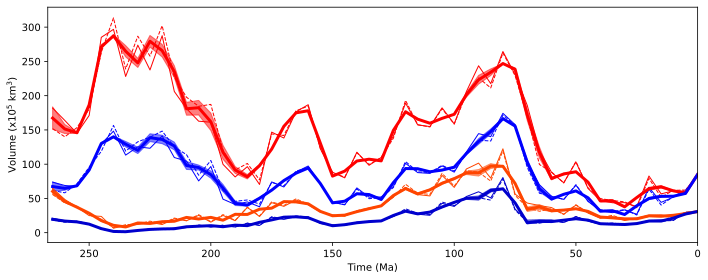

In [11]:
f, ax = plt.subplots(figsize=(10, 4))

ax.set(ylabel='Volume (x10$^5$ km$^3$)',
       xlabel='Time (Ma)')

# No limit
plt.plot(ntimes, fvolk, color = 'r', lw='1', ls='--',zorder=2)
plt.plot(ntimes, fkeepk, color = 'b', lw='1', ls='--',zorder=2)
plt.plot(ntimes, svolk, color = 'r', lw='1', ls='-',zorder=2)
plt.plot(ntimes, skeepk, color = 'b', lw='1', ls='-',zorder=2)
meanvolnolimit = np.mean(np.vstack((nolimit_vols,nolimit_volf)),axis=0)
plt.fill_between(ntimes,nolimit_vols,nolimit_volf, color='r', alpha=0.5)
plt.plot(ntimes, meanvolnolimit, color = 'r', lw='3', ls='-',zorder=2)
meankeepnolimit = np.mean(np.vstack((nolimit_keeps,nolimit_keepf)),axis=0)
plt.fill_between(ntimes,nolimit_keeps,nolimit_keepf, color='b', alpha=0.5)
plt.plot(ntimes, meankeepnolimit, color = 'b', lw='3', ls='-',zorder=2)

# Limit
plt.plot(ntimes, fvol, color = 'orangered', lw='1', ls='--',zorder=2)
plt.plot(ntimes, fkeep, color = 'mediumblue', lw='1', ls='--',zorder=2)
plt.plot(ntimes, svol, color = 'orangered', lw='1', ls='-',zorder=2)
plt.plot(ntimes, skeep, color = 'mediumblue', lw='1', ls='-',zorder=2)
meanvollimit = np.mean(np.vstack((limit_vols,limit_volf)),axis=0)
plt.fill_between(ntimes,limit_vols,limit_volf, color='orangered', alpha=0.5)
plt.plot(ntimes, meanvollimit, color = 'orangered', lw='3', ls='-',zorder=2)
meankeeplimit = np.mean(np.vstack((limit_keeps,limit_keepf)),axis=0)
plt.fill_between(ntimes,limit_keeps,limit_keepf, color='mediumblue', alpha=0.5)
plt.plot(ntimes, meankeeplimit, color = 'mediumblue', lw='3', ls='-',zorder=2)

# plt.plot(ntimes, keep, color = 'g', lw='2', ls='-',zorder=2)
# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
f.savefig('volume_values.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

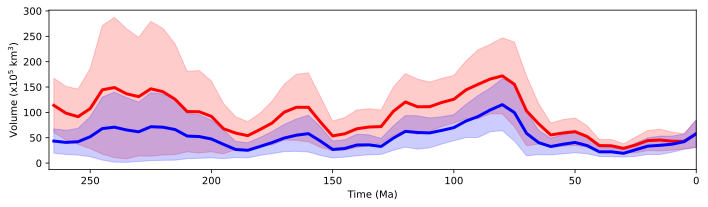

In [12]:
f, ax = plt.subplots(figsize=(10, 3))

ax.set(ylabel='Volume (x10$^5$ km$^3$)',
       xlabel='Time (Ma)')

mean_vol = np.mean(np.vstack((meanvollimit,meanvolnolimit)),axis=0)
plt.fill_between(ntimes,meanvollimit,meanvolnolimit, color='r', alpha=0.2)
plt.plot(ntimes, mean_vol, color = 'r', lw='3', ls='-',zorder=2)

mean_keep = np.mean(np.vstack((meankeeplimit,meankeepnolimit)),axis=0)
plt.fill_between(ntimes,meankeeplimit,meankeepnolimit, color='b', alpha=0.2)
plt.plot(ntimes, mean_keep, color = 'b', lw='3', ls='-',zorder=2)

# plt.plot(ntimes, keep, color = 'g', lw='2', ls='-',zorder=2)
# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
f.savefig('volume_values_mean.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

## Destroyed volume

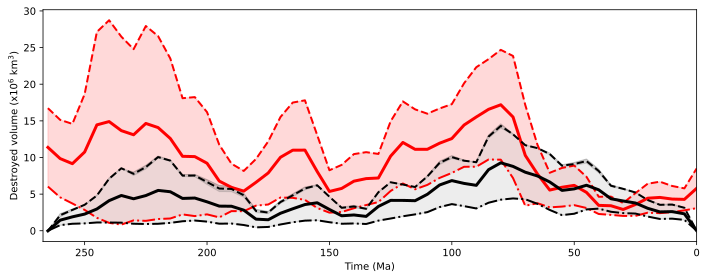

In [13]:
limit_dvolf = savgol_filter(voldestroyf, 7, 4) 
limit_dvols = savgol_filter(voldestroys, 7, 4)

nolimit_dvolf = savgol_filter(kvoldestroyf, 7, 4) 
nolimit_dvols = savgol_filter(kvoldestroys, 7, 4) 

f, ax = plt.subplots(figsize=(10, 4))

ax.set(ylabel='Destroyed volume (x10$^6$ km$^3$)',
       xlabel='Time (Ma)')

mean_vol = np.mean(np.vstack((meanvollimit,meanvolnolimit)),axis=0)
plt.fill_between(ntimes,meanvollimit/10,meanvolnolimit/10, color='r', alpha=0.15)
plt.plot(ntimes, mean_vol/10, color = 'r', lw='3', ls='-',zorder=2)

plt.plot(ntimes, meanvolnolimit/10, color = 'r', lw='2', ls='--',zorder=2)
plt.plot(ntimes, meanvollimit/10, color = 'r', lw='2', ls='-.',zorder=2)


destroy_kvol = np.mean(np.vstack((nolimit_dvolf,nolimit_dvols)),axis=0)
plt.fill_between(ntimes,nolimit_dvolf/1.e6,nolimit_dvols/1.e6, color='k', alpha=0.2)
plt.plot(ntimes, destroy_kvol/1.e6, color = 'k', lw='2', ls='--',zorder=2)

destroy_lvol = np.mean(np.vstack((limit_dvolf,limit_dvols)),axis=0)
plt.fill_between(ntimes,limit_dvolf/1.e6,limit_dvols/1.e6, color='grey', alpha=0.2)
plt.plot(ntimes, destroy_lvol/1.e6, color = 'k', lw='2', ls='-.',zorder=2)

meandest = np.mean(np.vstack((destroy_lvol,destroy_kvol)),axis=0)
plt.fill_between(ntimes,destroy_lvol/1.e6,destroy_kvol/1.e6, color='lightgrey', alpha=0.4)
plt.plot(ntimes, meandest/1.e6, color = 'k', lw='3', ls='-',zorder=2)

# mean_keep = np.mean(np.vstack((meankeeplimit,meankeepnolimit)),axis=0)
# plt.fill_between(ntimes,meankeeplimit,meankeepnolimit, color='b', alpha=0.2)
# plt.plot(ntimes, mean_keep, color = 'b', lw='3', ls='-',zorder=2)

# plt.plot(ntimes, keep, color = 'g', lw='2', ls='-',zorder=2)
# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
# f.savefig('volume_destroyed_mean.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

0.8 3 106 Gt CaCO .

petrophysical parameters (Aragonite density, ρA = 2950 kg m−3 and formation porosity, ΦR = 50%).

1 kg/m3 -> 1e6 t/km3

CaCO3 volume Vc = Vb ×[1−∅]×C
CaCO3 mass Mc =Vc ×𝜌


Molar mass of CaCO3 = 100.1 g/mol 

Mc*1.0e15/100.1

In [14]:
2950*(1-0.5)

1475.0

In [15]:
Vc_mean = mean_vol*(1-0.50)/10
Mc_mean = Vc_mean*2950*1.e6/1.e9

Vc_limit = meanvollimit*(1-0.50)/10
Mc_limit = Vc_limit*2950*1.e6/1.e9

Vc_nolimit = meanvolnolimit*(1-0.50)/10
Mc_nolimit = Vc_nolimit*2950*1.e6/1.e9

molarM_mean = Mc_mean*1.e15/100/5
molarM_limit = Mc_limit*1.e15/100/5
molarM_nolimit = Mc_nolimit*1.e15/100/5

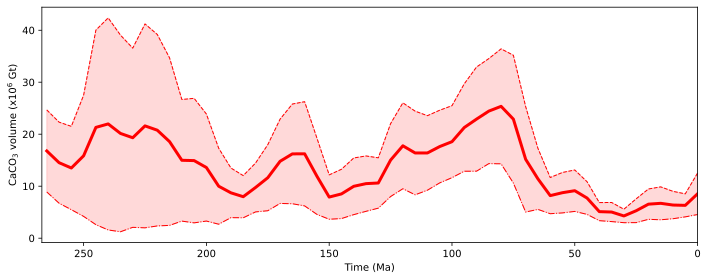

In [16]:
f, ax = plt.subplots(figsize=(10, 4))

ax.set(ylabel='CaCO$_3$ volume (x10$^6$ Gt)',
       xlabel='Time (Ma)')

plt.plot(ntimes, Mc_nolimit, color = 'r', lw='1', ls='--',zorder=2)
plt.plot(ntimes, Mc_limit, color = 'r', lw='1', ls='-.',zorder=2)

plt.plot(ntimes, Mc_mean, color = 'r', lw='3', ls='-',zorder=2)
plt.fill_between(ntimes,Mc_limit,Mc_nolimit, color='r', alpha=0.15)

# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
# f.savefig('volume_destroyed_mean.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

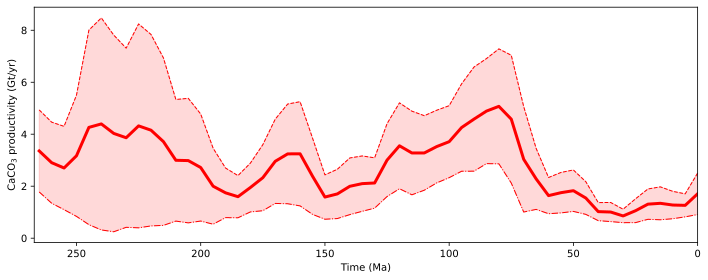

In [21]:
f, ax = plt.subplots(figsize=(10, 4))

ax.set(ylabel='CaCO$_3$ productivity (Gt/yr)',
       xlabel='Time (Ma)')

plt.plot(ntimes, Mc_mean/5., color = 'r', lw='3', ls='-',zorder=2)

plt.plot(ntimes, Mc_nolimit/5, color = 'r', lw='1', ls='--',zorder=2)
plt.plot(ntimes, Mc_limit/5, color = 'r', lw='1', ls='-.',zorder=2)
plt.fill_between(ntimes,Mc_limit/5,Mc_nolimit/5, color='r', alpha=0.15)

# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
f.savefig('productivity_mean_Gtyr.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

In [25]:
Mc_mean/5

array([3.35631849, 2.90500693, 2.69993843, 3.16982953, 4.26273801,
       4.396064  , 4.03035716, 3.86447896, 4.32056838, 4.1545819 ,
       3.71416143, 2.99684513, 2.98498122, 2.71757856, 1.999427  ,
       1.74447903, 1.59626044, 1.94964956, 2.32680296, 2.95799734,
       3.24302413, 3.2464348 , 2.38436814, 1.58197457, 1.70315743,
       1.99588853, 2.09875347, 2.12344621, 3.00379916, 3.55458108,
       3.2780185 , 3.27931662, 3.52494592, 3.71270389, 4.25691803,
       4.58133988, 4.88892044, 5.07242001, 4.57899849, 3.03464375,
       2.28211979, 1.63765769, 1.75046013, 1.82699772, 1.54407349,
       1.02142681, 1.00617376, 0.85538899, 1.05607075, 1.30921368,
       1.34134145, 1.27525544, 1.26295522, 1.70761819])

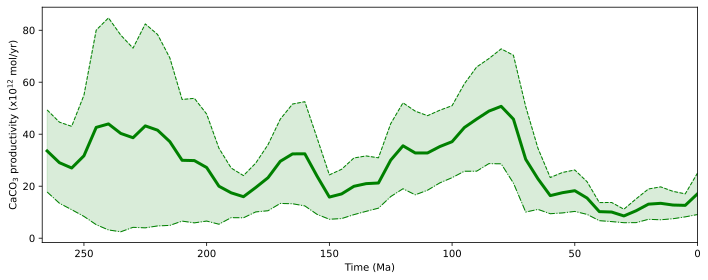

In [18]:
f, ax = plt.subplots(figsize=(10, 4))

ax.set(ylabel='CaCO$_3$ productivity (x10$^{12}$ mol/yr)',
       xlabel='Time (Ma)')

plt.plot(ntimes, molarM_mean/1.e12, color = 'g', lw='3', ls='-',zorder=2)
plt.plot(ntimes, molarM_nolimit/1.e12, color = 'g', lw='1', ls='--',zorder=2)
plt.plot(ntimes, molarM_limit/1.e12, color = 'g', lw='1', ls='-.',zorder=2)
plt.fill_between(ntimes,molarM_limit/1.e12,molarM_nolimit/1.e12, color='g', alpha=0.15)


# plt.plot(ntimes, molarM_mean*0.6/1.e12, color = 'k', lw='3', ls='-',zorder=2)
# plt.plot(ntimes, molarM_nolimit*0.6/1.e12, color = 'k', lw='1', ls='--',zorder=2)
# plt.plot(ntimes, molarM_limit*0.6/1.e12, color = 'k', lw='1', ls='-.',zorder=2)
# plt.fill_between(ntimes,molarM_limit*0.6/1.e12,molarM_nolimit*0.6/1.e12, color='k', alpha=0.15)


# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
f.savefig('CaCO3_mol_year.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

A maximum of 0.6 mol of CO2 are actually emitted for each mole of precipitated carbonate 

One mole of carbon dioxide molecules has a mass of 44.01g 

MassC = molarC*44.01 g/yr

every cubic meter of precipitated CaCO3 thus matches an emission of 8,850 mol CO2 , i.e., 389 kg CO2

In [25]:
v = 1.*(1-0.50) #m3
mcarb = v*2950*1000 #kg/m3
mcarb # (g/yr)

# Molar mass of CaCO3 = 100.1 g/mol
molcarb = mcarb/100.1 # mol/yr
molcarb

14735.264735264736

In [26]:
molco2 = molcarb*0.6
molco2 # mol/yr of CO2

mco2 = molco2*44.01 # g/yr
mco2

389099.40059940063

In [47]:
massCmean/1.e15

array([0.88626946, 0.76709613, 0.71294574, 0.83702519, 1.1256186 ,
       1.16082466, 1.06425611, 1.02045431, 1.14088929, 1.0970589 ,
       0.98076147, 0.79134692, 0.78821414, 0.71760379, 0.52796869,
       0.46064713, 0.42150853, 0.51482446, 0.61441559, 0.78108878,
       0.85635295, 0.85725357, 0.62961625, 0.41773621, 0.44973575,
       0.52703433, 0.55419684, 0.56071721, 0.79318321, 0.93862268,
       0.86559357, 0.86593635, 0.93079722, 0.98037659, 1.12408178,
       1.20974861, 1.29096833, 1.33942323, 1.20913034, 0.80132803,
       0.60261655, 0.43243989, 0.4622265 , 0.48243702, 0.40772805,
       0.26971796, 0.26569024, 0.22587402, 0.27886604, 0.34571096,
       0.35419462, 0.33674395, 0.33349596, 0.45091366])

In [28]:
molarCmean = molarM_mean*0.6
molarC_nolimit = molarM_nolimit*0.6
molarC_limit = molarM_limit*0.6

massCmean = molarCmean*44.01
massC_nolimit = molarC_nolimit*44.01
massC_limit = molarC_limit*44.01

reefCO2 = massCmean*0.13

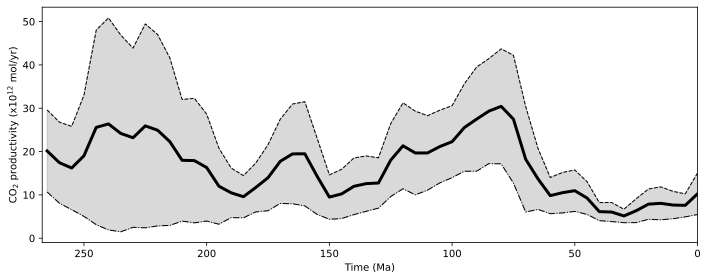

In [29]:
f, ax = plt.subplots(figsize=(10, 4))

ax.set(ylabel='CO$_2$ productivity (x10$^{12}$ mol/yr)',
       xlabel='Time (Ma)')

plt.plot(ntimes, molarCmean/1.e12, color = 'k', lw='3', ls='-',zorder=2)
plt.plot(ntimes, molarC_nolimit/1.e12, color = 'k', lw='1', ls='--',zorder=2)
plt.plot(ntimes, molarC_limit/1.e12, color = 'k', lw='1', ls='-.',zorder=2)
plt.fill_between(ntimes,molarC_limit/1.e12,molarC_nolimit/1.e12, color='k', alpha=0.15)

# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
f.savefig('CO2_prod.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

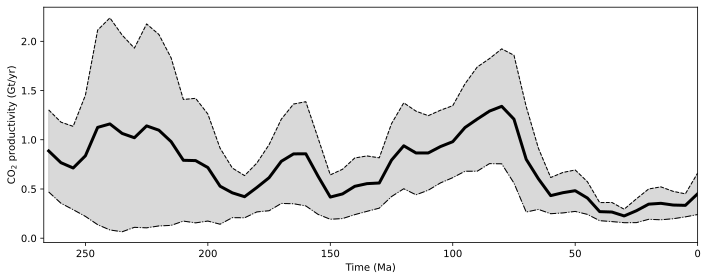

In [30]:
f, ax = plt.subplots(figsize=(10, 4))

ax.set(ylabel='CO$_2$ productivity (Gt/yr)',
       xlabel='Time (Ma)')

plt.plot(ntimes, massCmean/1.e15, color = 'k', lw='3', ls='-',zorder=2)
plt.plot(ntimes, massC_nolimit/1.e15, color = 'k', lw='1', ls='--',zorder=2)
plt.plot(ntimes, massC_limit/1.e15, color = 'k', lw='1', ls='-.',zorder=2)
plt.fill_between(ntimes,massC_limit/1.e15,massC_nolimit/1.e15, color='k', alpha=0.15)

# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
# f.savefig('volume_destroyed_mean.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

**In total, humans have pumped around 2,500bn tonnes of CO2 (GtCO2) into the atmosphere since 1850.**

@article{essd-12-3269-2020,
AUTHOR = {Friedlingstein, P. and O'Sullivan, M. and Jones, M. W. and Andrew, R. M. and Hauck, J. and Olsen, A. and Peters, G. P. and Peters, W. and Pongratz, J. and Sitch, S. and Le Qu\'er\'e, C. and Canadell, J. G. and Ciais, P. and Jackson, R. B. and Alin, S. and Arag\~ao, L. E. O. C. and Arneth, A. and Arora, V. and Bates, N. R. and Becker, M. and Benoit-Cattin, A. and Bittig, H. C. and Bopp, L. and Bultan, S. and Chandra, N. and Chevallier, F. and Chini, L. P. and Evans, W. and Florentie, L. and Forster, P. M. and Gasser, T. and Gehlen, M. and Gilfillan, D. and Gkritzalis, T. and Gregor, L. and Gruber, N. and Harris, I. and Hartung, K. and Haverd, V. and Houghton, R. A. and Ilyina, T. and Jain, A. K. and Joetzjer, E. and Kadono, K. and Kato, E. and Kitidis, V. and Korsbakken, J. I. and Landsch\"utzer, P. and Lef\`evre, N. and Lenton, A. and Lienert, S. and Liu, Z. and Lombardozzi, D. and Marland, G. and Metzl, N. and Munro, D. R. and Nabel, J. E. M. S. and Nakaoka, S.-I. and Niwa, Y. and O'Brien, K. and Ono, T. and Palmer, P. I. and Pierrot, D. and Poulter, B. and Resplandy, L. and Robertson, E. and R\"odenbeck, C. and Schwinger, J. and S\'ef\'erian, R. and Skjelvan, I. and Smith, A. J. P. and Sutton, A. J. and Tanhua, T. and Tans, P. P. and Tian, H. and Tilbrook, B. and van der Werf, G. and Vuichard, N. and Walker, A. P. and Wanninkhof, R. and Watson, A. J. and Willis, D. and Wiltshire, A. J. and Yuan, W. and Yue, X. and Zaehle, S.},
TITLE = {{Global Carbon Budget 2020}},
JOURNAL = {Earth System Science Data},
VOLUME = {12},
YEAR = {2020},
NUMBER = {4},
PAGES = {3269--3340},
URL = {https://essd.copernicus.org/articles/12/3269/2020/},
DOI = {10.5194/essd-12-3269-2020}
}

In [46]:
np.sum(massCmean*5*1.e6/1.e15) #Gt

194306531.7619767

3.7 Gt carbon dioxide will give 1 GtC

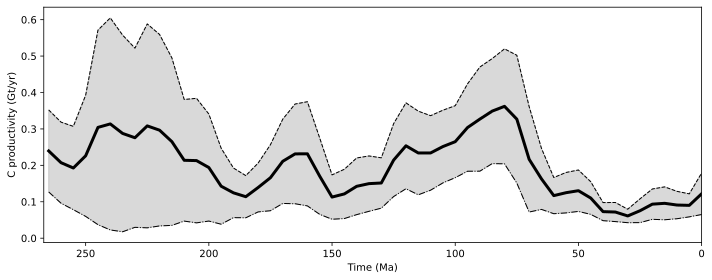

In [31]:
f, ax = plt.subplots(figsize=(10, 4))

ax.set(ylabel='C productivity (Gt/yr)',
       xlabel='Time (Ma)')

plt.plot(ntimes, massCmean/1.e15/3.7, color = 'k', lw='3', ls='-',zorder=2)
plt.plot(ntimes, massC_nolimit/1.e15/3.7, color = 'k', lw='1', ls='--',zorder=2)
plt.plot(ntimes, massC_limit/1.e15/3.7, color = 'k', lw='1', ls='-.',zorder=2)
plt.fill_between(ntimes,massC_limit/1.e15/3.7,massC_nolimit/1.e15/3.7, color='k', alpha=0.15)

# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
# f.savefig('volume_destroyed_mean.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

1 GtCO2/yr increases atmospheric pCO2 by 0.13 ppmv.

Using our 44 over 12 rule, 1ppm = 7.8 Gigatonnes of Carbon Dioxide in the atmosphere

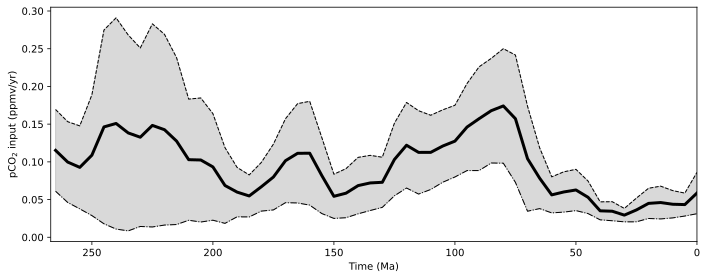

In [32]:
f, ax = plt.subplots(figsize=(10, 4))

ax.set(ylabel='pCO$_2$ input (ppmv/yr)',
       xlabel='Time (Ma)')

plt.plot(ntimes, massCmean*0.13/1.e15, color = 'k', lw='3', ls='-',zorder=2)
plt.plot(ntimes, massC_nolimit*0.13/1.e15, color = 'k', lw='1', ls='--',zorder=2)
plt.plot(ntimes, massC_limit*0.13/1.e15, color = 'k', lw='1', ls='-.',zorder=2)
plt.fill_between(ntimes,massC_limit*0.13/1.e15,massC_nolimit*0.13/1.e15, color='k', alpha=0.15)

# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
# f.savefig('volume_destroyed_mean.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

In [33]:
CO2data = pd.read_csv('../paleo_reef/data/simdata.csv',sep='	')
CO2val = CO2data['CO2 (in ppmv)'].values
CO2vals = CO2val[:len(ntimes)]
CO2valf = CO2val[len(ntimes):]
# sCO2time = (-smoothCO2['Time (Ma)']).to_list()
# sCO2SST = (smoothCO2['SST mean']).to_list()
# smoothCO2
CO2valf

array([ 320.82,  352.02,  810.9 ,  878.74,  418.58, 1033.59, 1491.97,
       1613.52, 2059.04, 1810.4 , 1481.01, 1223.32, 1503.18, 1728.9 ,
       1783.74, 1180.68,  948.81,  986.22, 1046.43, 1018.89,  867.55,
        785.38,  802.03,  721.3 ,  713.01,  831.71, 1020.29,  896.15,
        897.93,  986.19, 1102.96, 1148.07, 1028.16, 1007.8 ,  707.39,
        465.65,  590.28,  667.16,  559.27,  261.65,  228.84,  334.83,
        570.28,  735.76,  751.41,  795.57,  901.42,  763.85,  502.09,
        338.28,  310.19,  299.4 ,  298.33,  276.01])

In [34]:
reefCO2 = massCmean*0.13/1.e15

reefCO2_nl = massC_nolimit*0.13/1.e15
reefCO2_l = massC_limit*0.13/1.e15

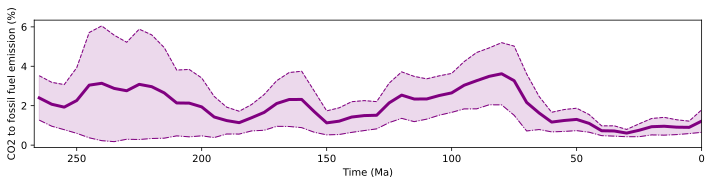

In [35]:
f, ax = plt.subplots(figsize=(10, 2.5))

ax.set(ylabel='CO2 to fossil fuel emission (%)',
       xlabel='Time (Ma)')

# ax.set(ylabel='CO$_2$ productivity (Gt/yr)',
#        xlabel='Time (Ma)')

plt.plot(ntimes, massCmean*100/1.e15/37, color = 'purple', lw='3', ls='-',zorder=2)
plt.plot(ntimes, massC_nolimit*100/1.e15/37, color = 'purple', lw='1', ls='--',zorder=2)
plt.plot(ntimes, massC_limit*100/1.e15/37, color = 'purple', lw='1', ls='-.',zorder=2)
plt.fill_between(ntimes,massC_limit*100/1.e15/37,massC_nolimit*100/1.e15/37, color='purple', alpha=0.15)


# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
f.savefig('perc_fuelemission.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

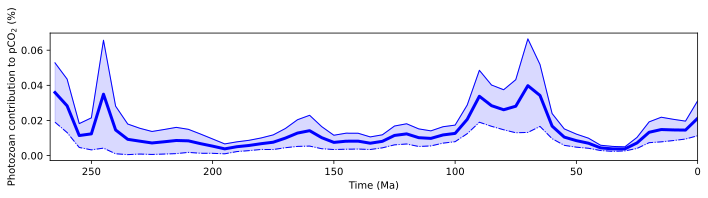

In [36]:
f, ax = plt.subplots(figsize=(10, 2.5))

ax.set(ylabel='Photozoan contribution to pCO$_2$ (%)',
       xlabel='Time (Ma)')

plt.plot(ntimes, reefCO2*100/CO2valf, color = 'b', lw='3', ls='-',zorder=2)
plt.plot(ntimes, reefCO2_nl*100/CO2valf, color = 'b', lw='1', ls='-',zorder=2)
plt.plot(ntimes, reefCO2_l*100/CO2valf, color = 'b', lw='1', ls='-.',zorder=2)
plt.fill_between(ntimes,reefCO2_l*100/CO2valf,reefCO2_nl*100/CO2valf, color='b', alpha=0.15)

# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
f.savefig('contrib_pCO2.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

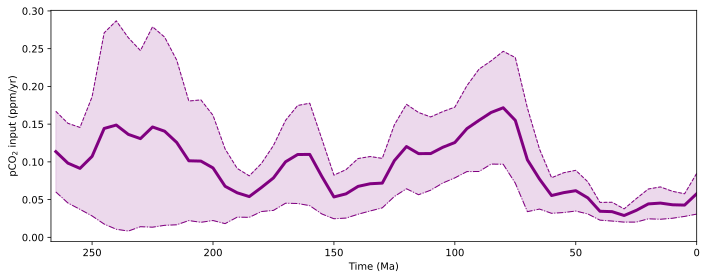

In [37]:
f, ax = plt.subplots(figsize=(10, 4))

ax.set(ylabel='pCO$_2$ input (ppm/yr)',
       xlabel='Time (Ma)')

plt.plot(ntimes, massCmean/1.e15/7.8, color = 'purple', lw='3', ls='-',zorder=2)
plt.plot(ntimes, massC_nolimit/1.e15/7.8, color = 'purple', lw='1', ls='--',zorder=2)
plt.plot(ntimes, massC_limit/1.e15/7.8, color = 'purple', lw='1', ls='-.',zorder=2)
plt.fill_between(ntimes,massC_limit/1.e15/7.8,massC_nolimit/1.e15/7.8, color='purple', alpha=0.15)

# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
f.savefig('CO2_ppm.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show() 

## Shelf depth

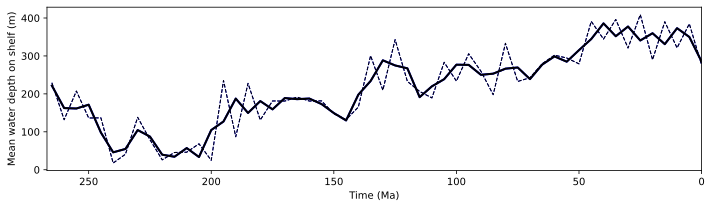

In [38]:
f, ax = plt.subplots(figsize=(10, 3))

ax.set(ylabel='Mean water depth on shelf (m)',
       xlabel='Time (Ma)')

depthf = savgol_filter(fmeandepth, 5, 3) 
plt.plot(ntimes, depthf, color = 'b', lw='2', ls='-',zorder=2)
plt.plot(ntimes, fmeandepth, color = 'b', lw='1', ls='--',zorder=2)

depths = savgol_filter(smeandepth, 5, 3) 
plt.plot(ntimes, depths, color = 'k', lw='2', ls='-',zorder=2)
plt.plot(ntimes, smeandepth, color = 'k', lw='1', ls='--',zorder=2)

# plt.plot(ntimes, keep, color = 'g', lw='2', ls='-',zorder=2)
# plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
f.savefig('depth_shelf.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

## Area photozoan

In [39]:
jonesData = pd.read_csv('../paleo_reef/data/JonesData.csv')

In [40]:
df_boundJones = pd.DataFrame(
    data={
        "x": -jonesData['mid_ma'],
        "y": np.mean(np.vstack((jonesData['LPT_global'],jonesData['MaxSSS_global'])),axis=0),
        "y_bound_low": jonesData['MaxSSS_global'],
        "y_bound_upp": jonesData['LPT_global'],
    }
)

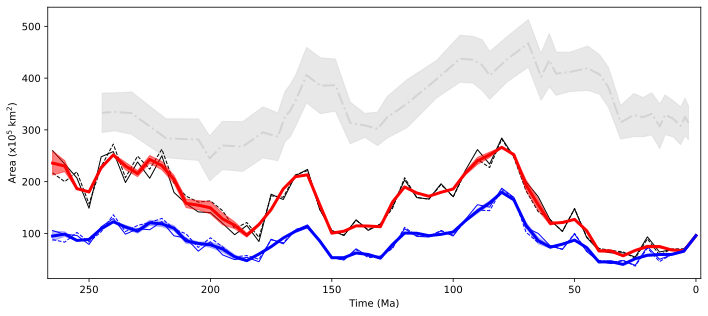

In [41]:
f, ax = plt.subplots(figsize=(10, 4.5))

ax.set(ylabel='Area (x10$^5$ km$^2$)',
       xlabel='Time (Ma)')
# plt.plot(ntimes, sarea, color = 'b', lw='2', ls='-',zorder=2)

plt.fill_between(jonesData['mid_ma'],jonesData['MaxSSS_global'],
                 jonesData['LPT_global'], color='lightgrey', alpha=0.5)

meanjones = np.mean(np.vstack((jonesData['LPT_global'],jonesData['MaxSSS_global'])),axis=0)
plt.plot(jonesData['mid_ma'],meanjones,lw='2', ls='-.',zorder=2,color = 'lightgrey')

areas = savgol_filter(sarea, 7, 4)
areaf = savgol_filter(farea, 7, 4)  
plt.plot(ntimes, farea, color = 'k', lw='1', ls='--',zorder=1)
plt.plot(ntimes, sarea, color = 'k', lw='1', ls='-',zorder=1)
meanareas = np.mean(np.vstack((areas,areaf)),axis=0)
plt.fill_between(ntimes,areas,areaf, color='r', alpha=0.5)
plt.plot(ntimes, meanareas, color = 'r', lw='3', ls='-',zorder=2)

press = savgol_filter(sApresk, 7, 4)
presf = savgol_filter(fApresk, 7, 4) 
plt.plot(ntimes, fApresk, color = 'b', lw='1', ls='--',zorder=1)
plt.plot(ntimes, sApresk, color = 'b', lw='1', ls='-',zorder=1)
meanpres = np.mean(np.vstack((press,presf)),axis=0)
plt.fill_between(ntimes,press,presf, color='b', alpha=0.25)
plt.plot(ntimes, meanpres, color = 'b', lw='3', ls='-',zorder=2)

# plt.ylim(-5, 105)
plt.xlim(-2, 267)
ax.invert_xaxis()
f.tight_layout()
f.savefig('area_reef.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

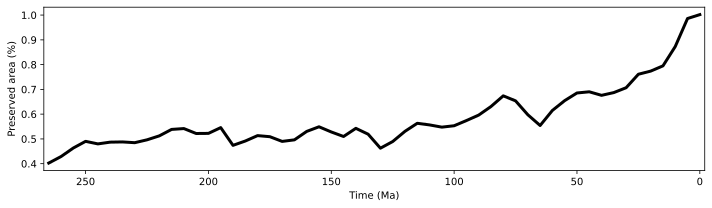

In [42]:
f, ax = plt.subplots(figsize=(10, 3))

ax.set(ylabel='Preserved area (%)',
       xlabel='Time (Ma)')
# plt.plot(ntimes, sarea, color = 'b', lw='2', ls='-',zorder=2)

# plt.fill_between(jonesData['mid_ma'],jonesData['MaxSSS_global'],
#                  jonesData['LPT_global'], color='lightgrey', alpha=0.5)

plt.plot(ntimes,(meanpres/meanareas),lw='3', ls='-',zorder=2,color = 'k')

# plt.ylim(-5, 105)
plt.xlim(-2, 267)
ax.invert_xaxis()
f.tight_layout()
f.savefig('pres_area.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()